In [3]:
from qiskit import QuantumCircuit

def get_test_circuit(n_qubits=5):
    qc = QuantumCircuit(n_qubits)
    
    # 1. Create Superposition on the first qubit
    # (Tests single-qubit 'r' gate noise)
    qc.h(0)
    
    # 2. Entangle neighbors linearly (Chain)
    # (Tests two-qubit 'cx' crosstalk/ZZ noise)
    for i in range(n_qubits - 1):
        qc.cx(i, i+1)
        
    # 3. Measurement (Optional, depending on if your simulator needs it)
    qc.measure_all()
    
    return qc

# Generate and print
qc = get_test_circuit(5)
print(qc.draw("mpl"))

Figure(1082.05x535.111)


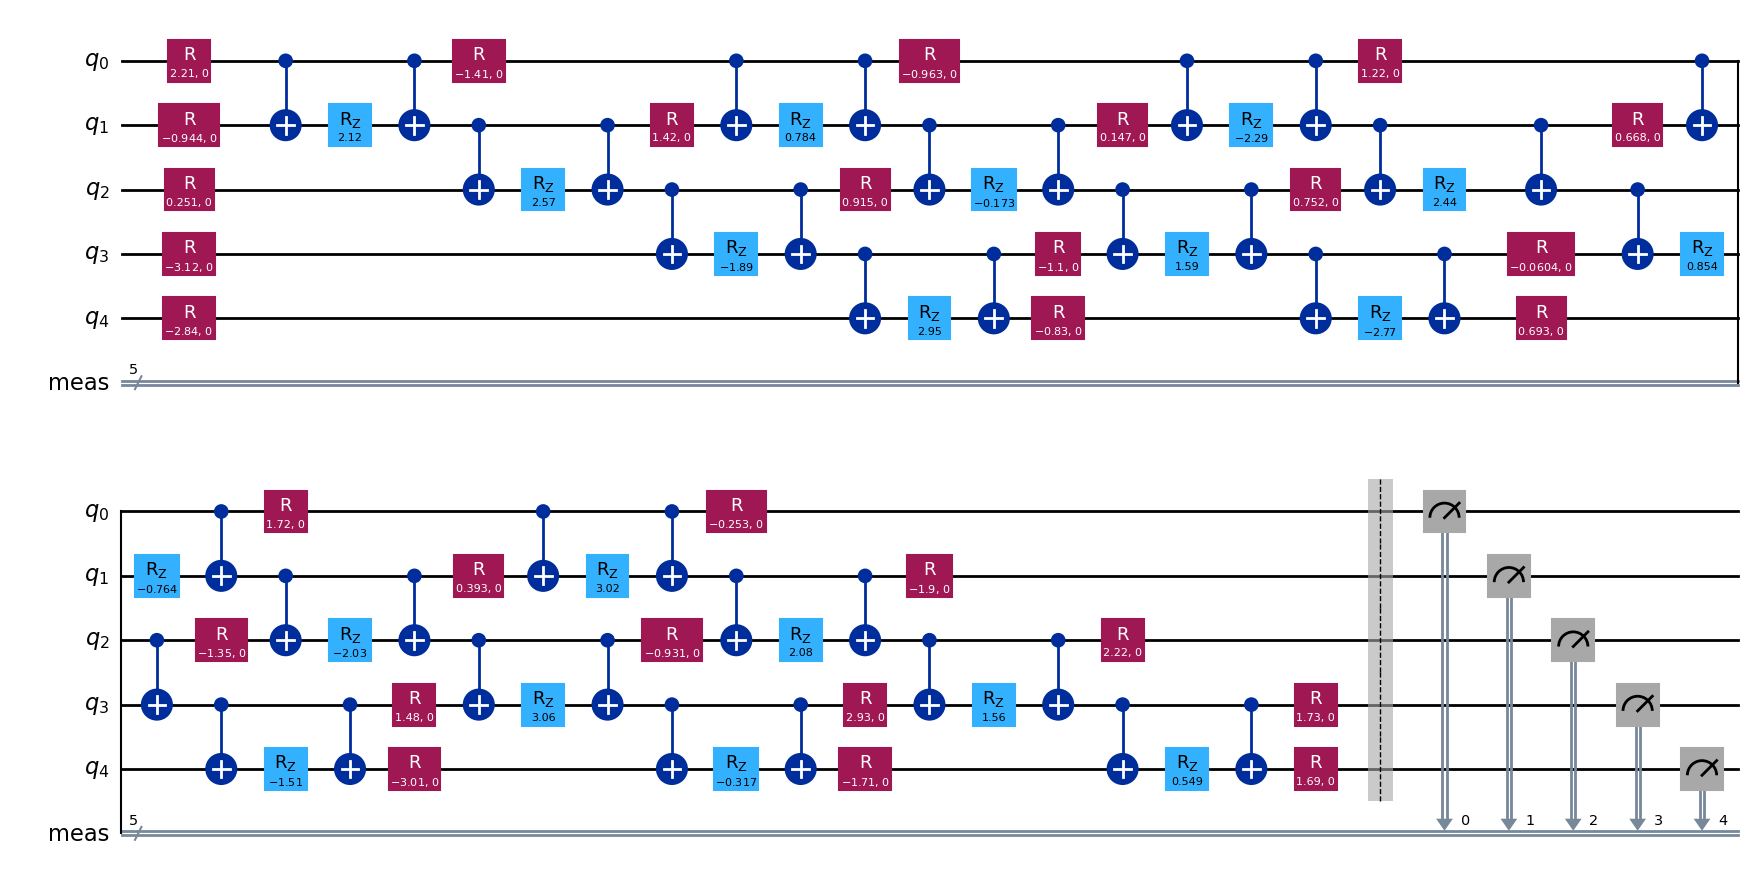

In [4]:
import qiskit.circuit.library.n_local as TwoLocal

import numpy as np

num_qubits = 5
circuit = TwoLocal(num_qubits, ["rx"], ["rzz"], entanglement="linear", reps=num_qubits).decompose()
num_pars = len(circuit.parameters)
rng = np.random.default_rng()
values = rng.uniform(-np.pi, np.pi, size=num_pars)
circuit.assign_parameters(values, inplace=True)
circuit.measure_all()
circuit.draw(output="mpl")

In [5]:
from qiskit.circuit import Instruction, CircuitInstruction
import numpy as np

# 1. Define your Error Function
# This determines the 'strength' of the RX error based on context
def get_coherent_error_angle(qubit_index, gate_name):
    """
    Returns the angle for the RX error gate.
    Logic: 
    - Faster gates (R) might have small over-rotations.
    - Two-qubit gates (CX) usually induce larger errors on both qubits.
    - specific qubits (e.g., q[4]) might be 'bad' qubits with higher error.
    """
    
    # Base error rates
    ## Replace with learned matrix later...
    if gate_name == 'cx':
        base_error = 0.05  # Larger error for entangling gates
    elif gate_name == 'r':
        base_error = 0.01  # Smaller error for single rotations
    elif gate_name == 'rz':
        base_error = 0.005 # Z-rotations are usually virtual and precise
    else:
        return 0.0 # No error for other gates

    # Qubit specific multiplier (e.g., Qubit 4 is noisy)
    qubit_multiplier = 1.5 if qubit_index == 4 else 1.0
    
    return base_error * qubit_multiplier

# 2. The Injection Logic
def insert_coherent_rx_noise(original_instructions):
    noisy_instructions = []
    
    # Gates we should NOT put noise after
    # Adding gates after 'measure' usually breaks simulators
    ignore_ops = ['barrier', 'measure', 'reset']

    for instr in original_instructions:
        # A. Append the original instruction first
        noisy_instructions.append(instr)
        
        op_name = instr.operation.name
        
        # Skip if this is a barrier/measure
        if op_name in ignore_ops:
            continue
            
        # B. Iterate through all qubits involved in this gate
        # (Works for 1-qubit 'r' and 2-qubit 'cx')
        for q in instr.qubits:
            # q is a Qubit object, we need its index
            q_idx = q.index
            
            # C. Calculate the error angle
            theta_error = get_coherent_error_angle(q_idx, op_name)
            
            if theta_error != 0:
                # D. Create the RX Error Gate
                # Note: We use the exact class structure from your input
                rx_op = Instruction(
                    name='r', # Using 'r' as a generic single qubit rotation
                    num_qubits=1, 
                    num_clbits=0, 
                    params=[theta_error, 0.0] # [theta, phi] for RX, phi=0
                )
                
                # Create the instruction wrapper
                error_instr = CircuitInstruction(
                    operation=rx_op,
                    qubits=(q,),
                    clbits=()
                )
                
                noisy_instructions.append(error_instr)
                
    return noisy_instructions

# Usage:
# noisy_list = insert_coherent_rx_noise(your_instruction_list)

In [ ]:
add_coherent_rx_noise(circuit).draw("mpl")

In [16]:
def get_coherent_error_angle(qubit_index, gate_name):
    """
    Returns the angle for the RX error gate.
    Logic: 
    - Faster gates (R) might have small over-rotations.
    - Two-qubit gates (CX) usually induce larger errors on both qubits.
    - specific qubits (e.g., q[4]) might be 'bad' qubits with higher error.
    """
    
    # Base error rates
    ## Replace with learned matrix later...
    if gate_name == 'cz0':
        base_error = 0.001 # Larger error for entangling gates
    elif gate_name == 'cz1':
        base_error = 0.01  # Larger error for entangling gates
    elif gate_name == 'r':
        base_error = 0.01  # Smaller error for single rotations
    elif gate_name == 'rz':
        base_error = 0.005 # Z-rotations are usually virtual and precise
    else:
        print(gate_name)
        return 0.0 # No error for other gates

    # Qubit specific multiplier (e.g., Qubit 4 is noisy)
    qubit_multiplier = 1.5 if qubit_index == 4 else 1.0
    
    return base_error * qubit_multiplier

In [15]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate

def add_coherent_rx_noise(original_qc: QuantumCircuit) -> QuantumCircuit:
    """
    Takes a clean QuantumCircuit and returns a new one with 
    coherent RX errors injected after every gate.
    """
    # 1. Create a new empty circuit
    noisy_qc = original_qc.copy_empty_like()
    
    ignore_ops = {'measure', 'barrier', 'reset', 'snapshot'}

    # 3. Iterate through the original instructions
    for instruction in original_qc.data:
        
        # A. Append the original gate
        noisy_qc.append(instruction)
        
        op_name = instruction.operation.name
        
        # B. Check if we should inject noise
        if op_name == 'cz':
            control_switch = 0
            for q in instruction.qubits:
                # --- FIX 1: Use find_bit(q).index ---
                q_idx = original_qc.find_bit(q).index
                
                theta_error = get_coherent_error_angle(q_idx, op_name + str(control_switch))
    
                if theta_error != 0:
                    # --- FIX 2: Fixed typo 'theta_error_0' -> 'theta_error' ---
                    rx_error = RXGate(theta_error)
                    noisy_qc.append(rx_error, [q])
                    
                control_switch = 1

        elif op_name not in ignore_ops:
            
            # C. Inject RX error on *each* qubit involved
            for q in instruction.qubits:
                # --- FIX 1: Use find_bit(q).index ---
                q_idx = original_qc.find_bit(q).index

                theta_error = get_coherent_error_angle(q_idx, op_name)
                
                if theta_error != 0:
                    rx_error = RXGate(theta_error)
                    noisy_qc.append(rx_error, [q])
                
    return noisy_qc

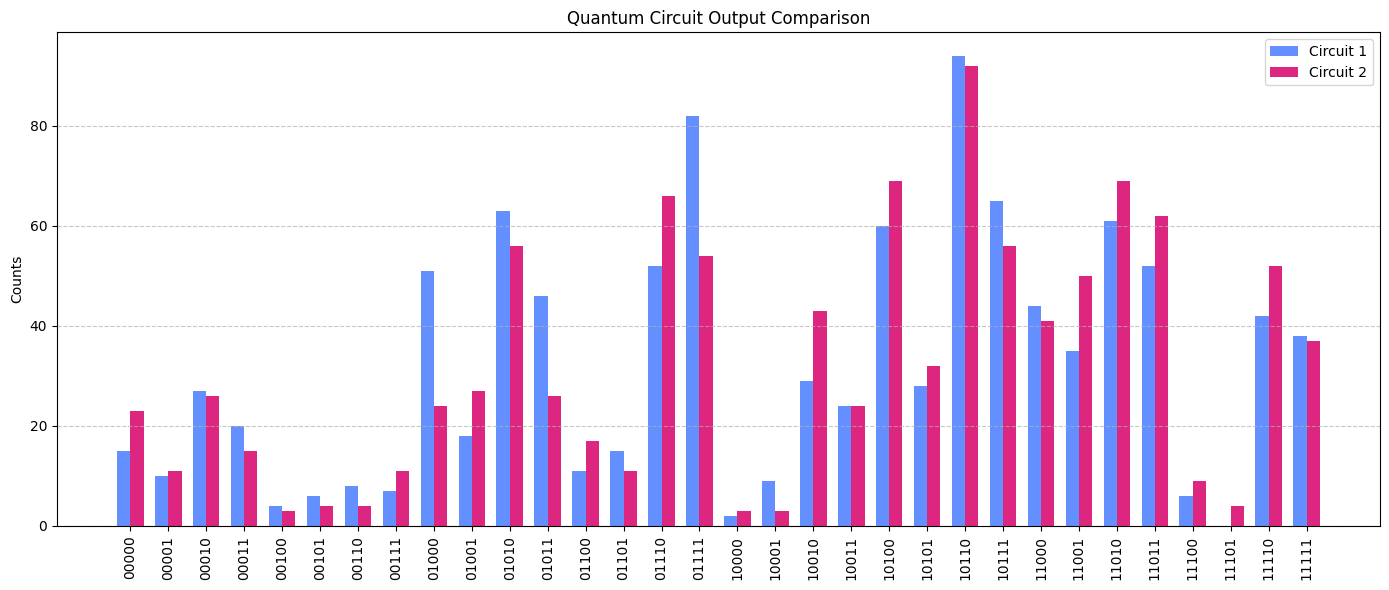

In [8]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt
noisy_circuit = add_coherent_rx_noise(circuit)

sampler = StatevectorSampler()
result = sampler.run([circuit], shots=1024).result()
noisy_result = sampler.run([noisy_circuit], shots=1024).result()
counts = result[0].data.meas.get_counts()
noisy_counts = noisy_result[0].data.meas.get_counts()


import matplotlib.pyplot as plt
import numpy as np

counts_1 = counts
counts_2 = noisy_counts

all_keys = set(counts_1.keys()) | set(counts_2.keys())

# Sort keys to ensure the X-axis is in binary order (00000 -> 11111)
sorted_keys = sorted(list(all_keys))

# Create lists of values aligned to the sorted keys
# .get(key, 0) ensures we put a 0 if that bitstring didn't occur in a specific circuit
values_1 = [counts_1.get(key, 0) for key in sorted_keys]
values_2 = [counts_2.get(key, 0) for key in sorted_keys]

# 3. Plotting
x = np.arange(len(sorted_keys))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(14, 6)) # Wide figure to fit labels

# Plot the two sets of bars, offset by +/- width/2
rects1 = ax.bar(x - width/2, values_1, width, label='Circuit 1', color='#648FFF')
rects2 = ax.bar(x + width/2, values_2, width, label='Circuit 2', color='#DC267F')

# 4. Formatting
ax.set_ylabel('Counts')
ax.set_title('Quantum Circuit Output Comparison')
ax.set_xticks(x)
ax.set_xticklabels(sorted_keys, rotation=90) # Rotate labels for readability
ax.legend()

# Optional: Add grid for easier reading of height
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [9]:
# Optional: Add text labels on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        # Only label significant bars to avoid clutter
        if height > 10: 
            ax.annotate(f'{int(height)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8, rotation=90)

autolabel(rects1)
autolabel(rects2)


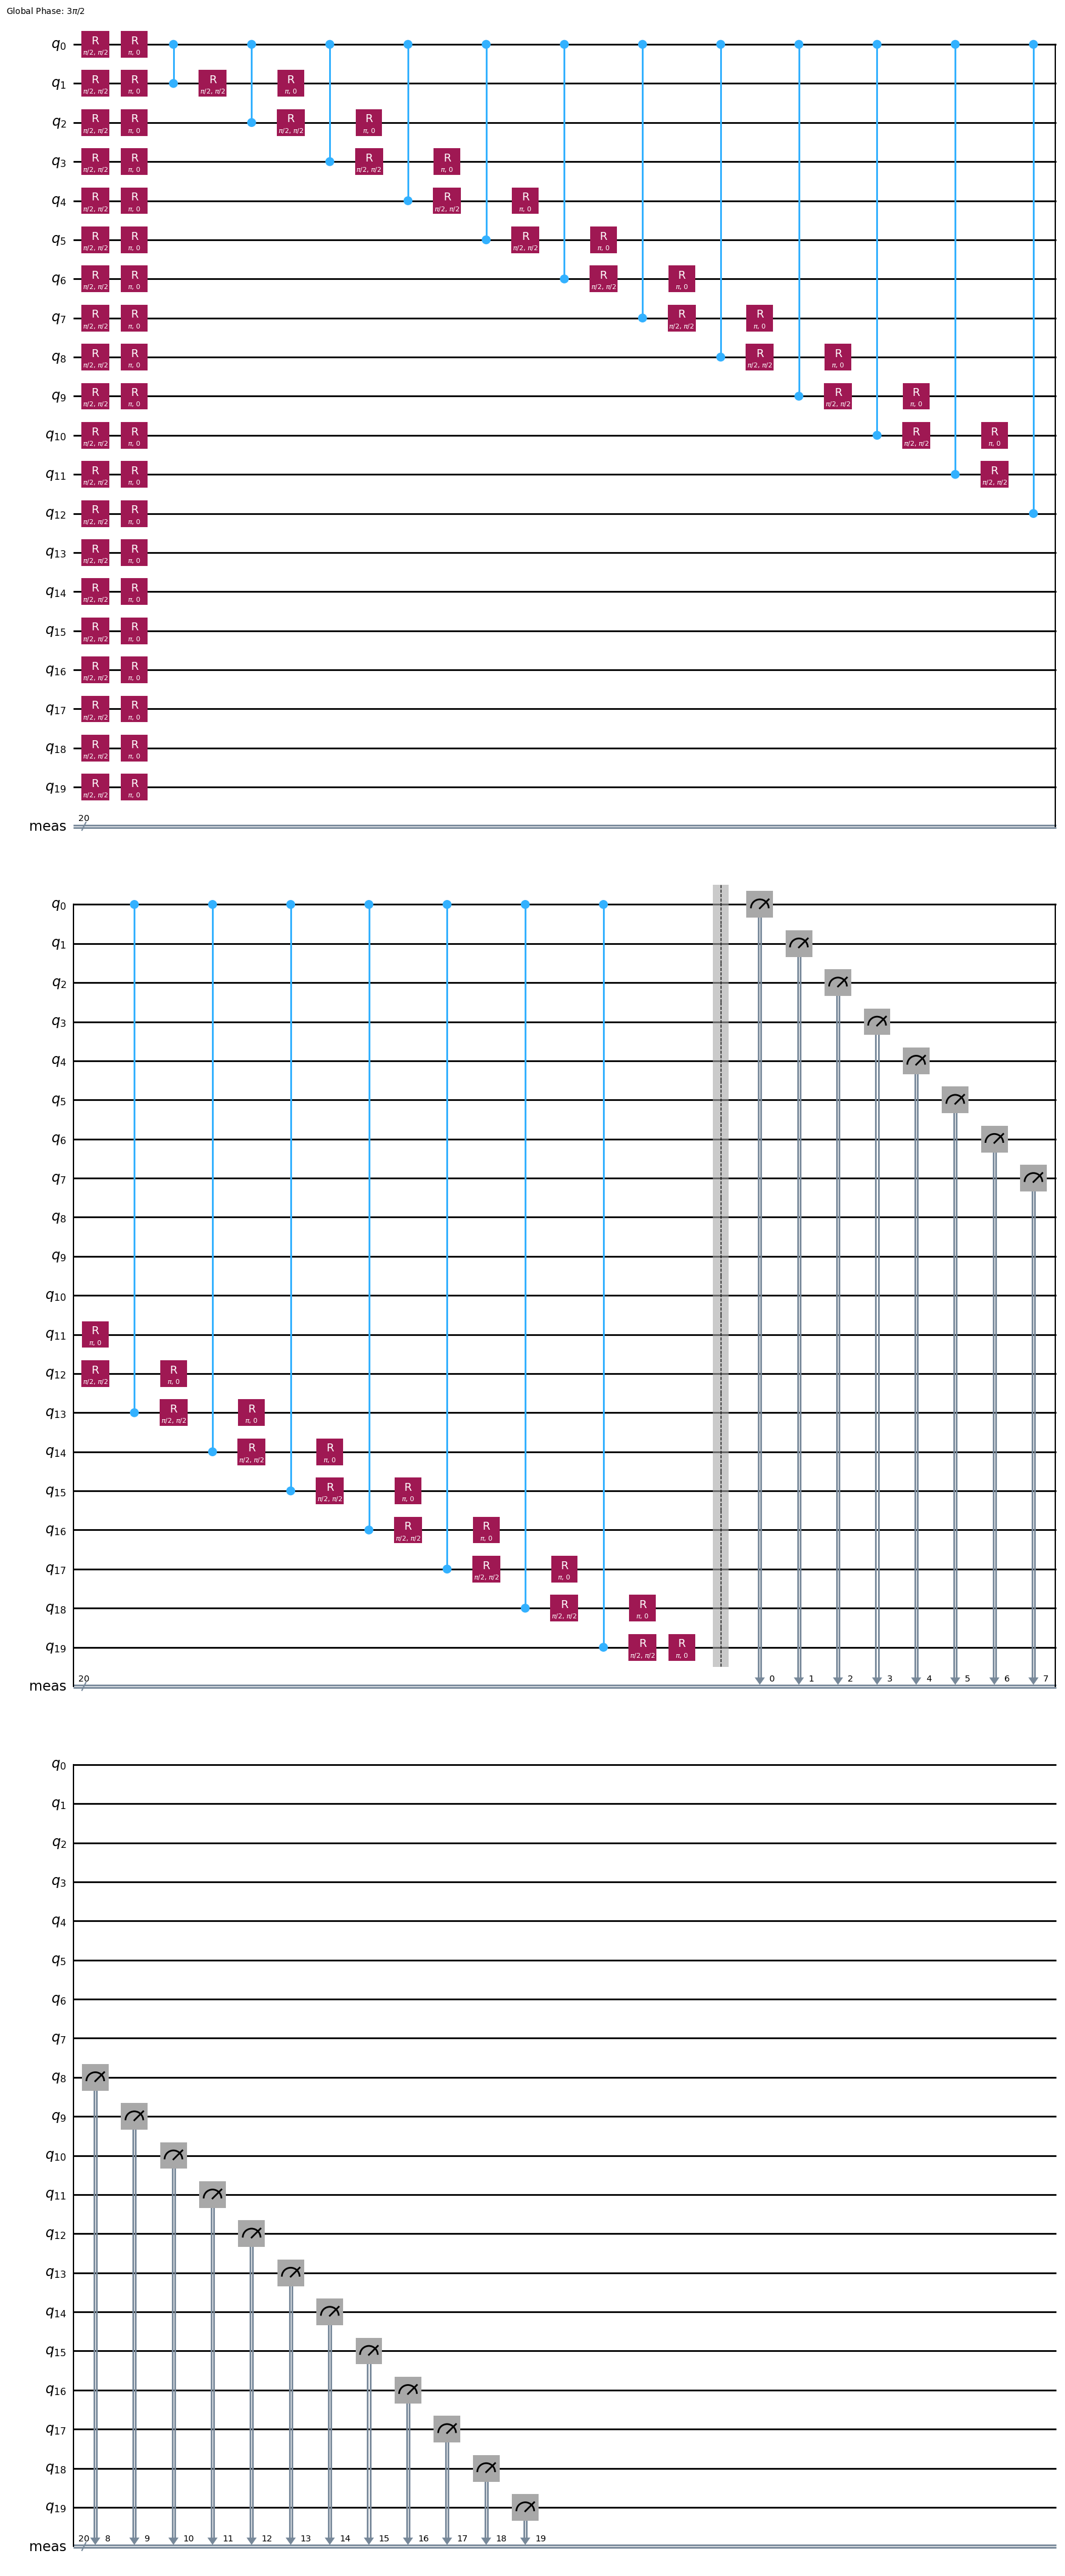

In [18]:
circuit.draw("mpl")


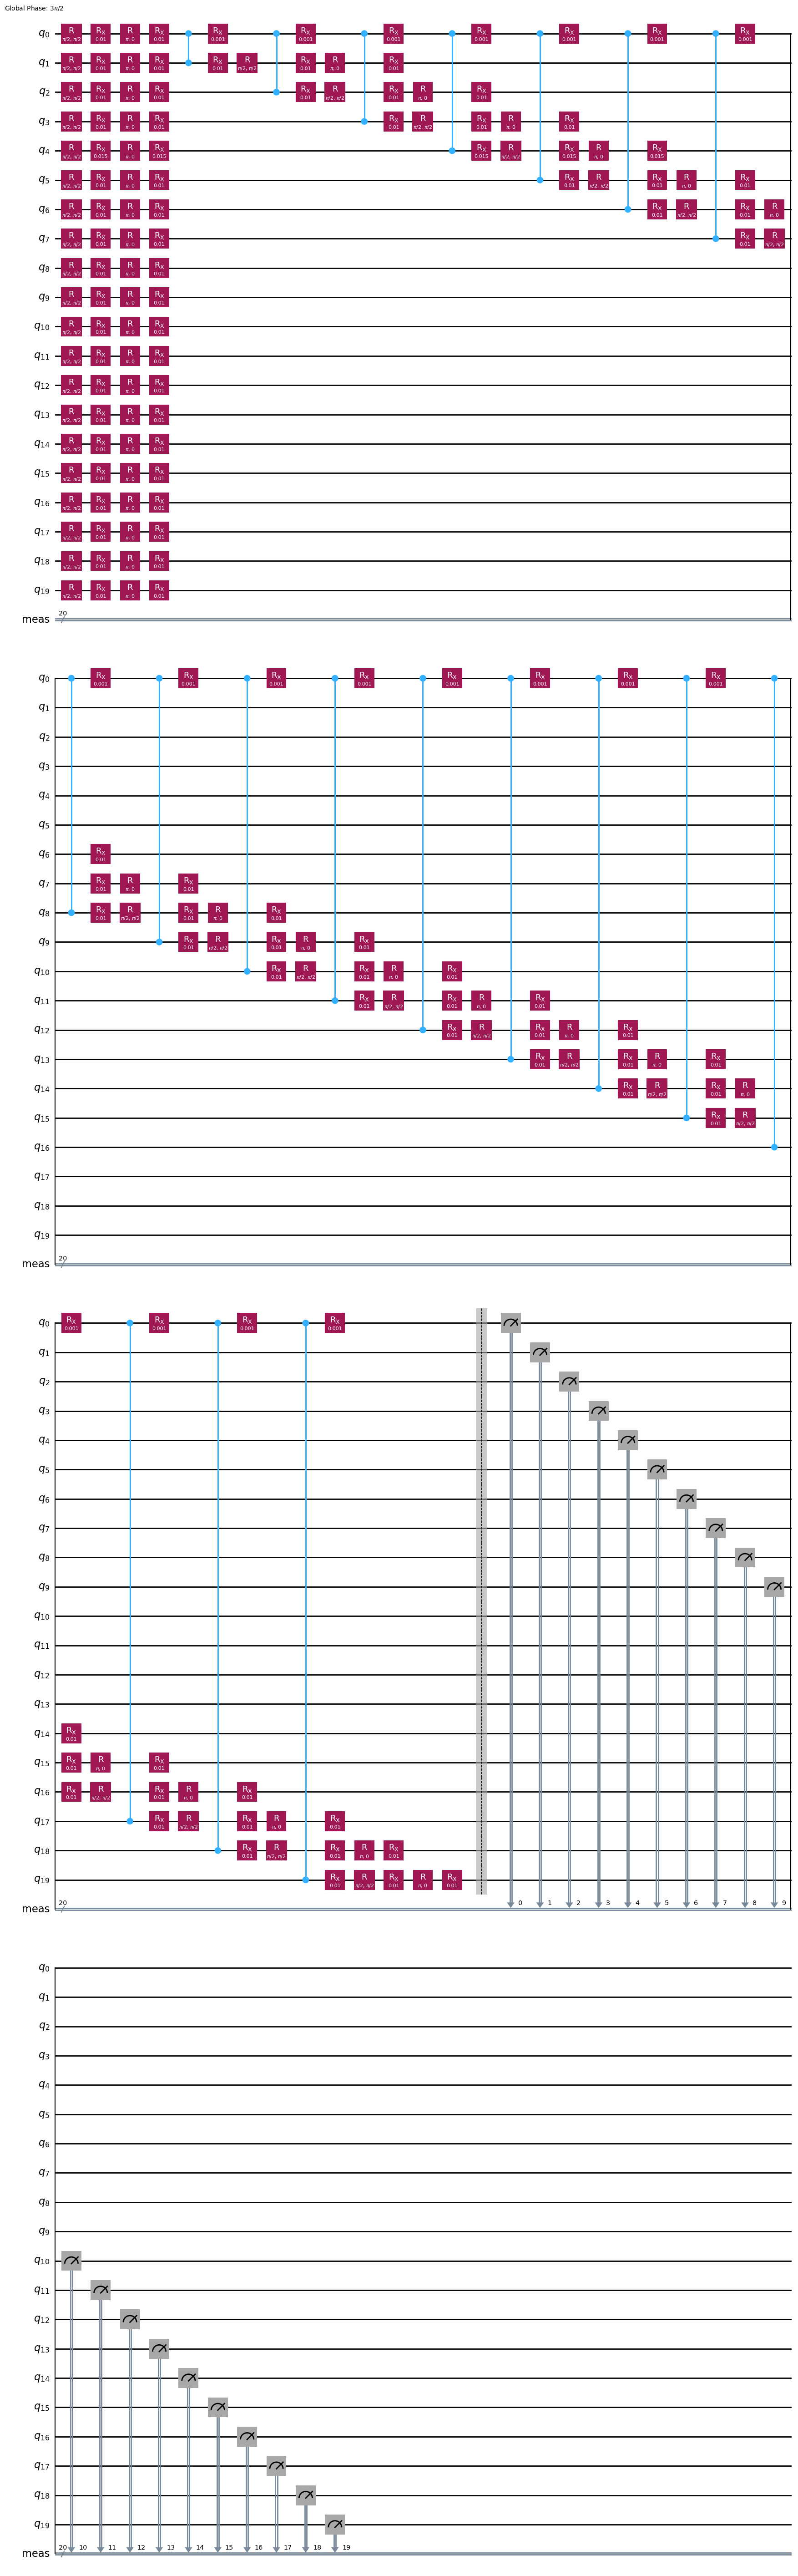

In [20]:
from qiskit import QuantumCircuit, transpile

# set seed for reproducibility
seed = 42
num_qubits = 20
 
# Create GHZ circuit
qc = QuantumCircuit(num_qubits)
qc.h(0)
for i in range(1, num_qubits):
    qc.cx(0, i)
 
qc.measure_all()

native_gates = ['r', 'rz', 'cz'] 

# 3. Transpile
# optimization_level=3 tries hardest to reduce gate count
circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
noisy_circuit = add_coherent_rx_noise(circuit)

circuit.draw("mpl")
noisy_circuit.draw("mpl")

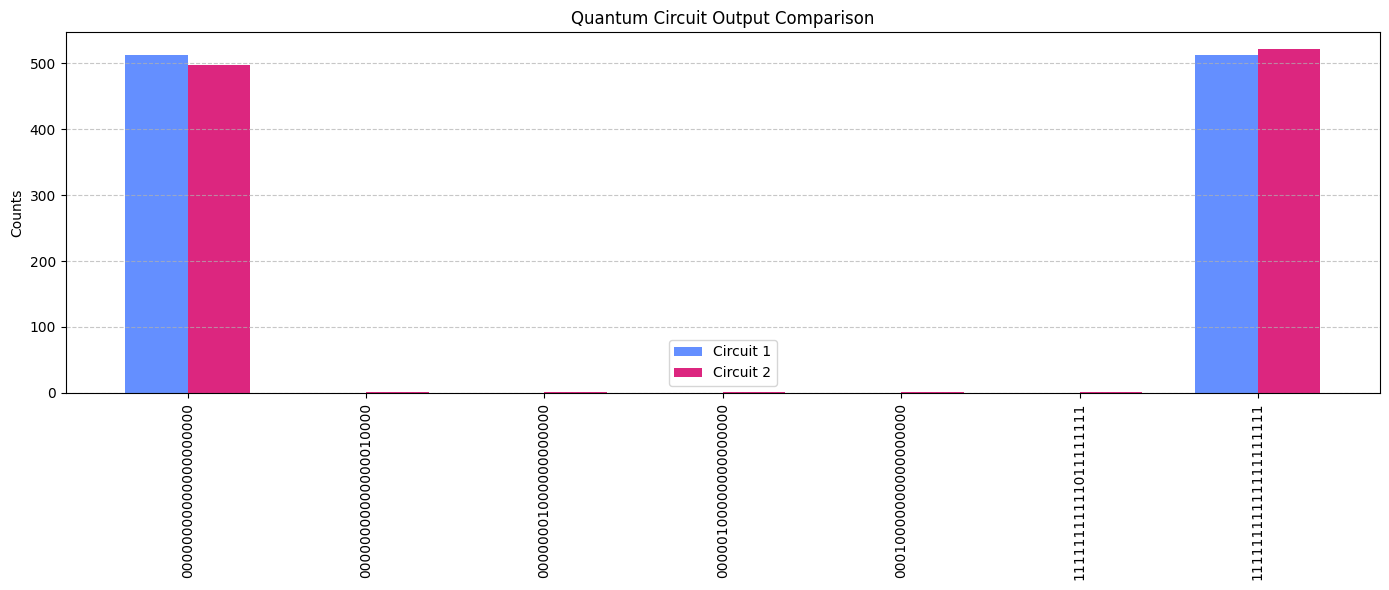

In [19]:
from qiskit import QuantumCircuit, transpile

# set seed for reproducibility
seed = 42
num_qubits = 20
 
# Create GHZ circuit
qc = QuantumCircuit(num_qubits)
qc.h(0)
for i in range(1, num_qubits):
    qc.cx(0, i)
 
qc.measure_all()

native_gates = ['r', 'rz', 'cz'] 

# 3. Transpile
# optimization_level=3 tries hardest to reduce gate count
circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
noisy_circuit = add_coherent_rx_noise(circuit)

# transpiled_qc.draw("mpl")

from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator

# 1. Use AerSimulator instead of StatevectorSampler
simulator = AerSimulator()

# 2. Run the circuit (run directly, no need for [list])
# This returns a Job, so we call .result()
result = simulator.run(circuit, shots=1024).result()
noisy_result = simulator.run(noisy_circuit, shots=1024).result()

# 3. Get counts
counts = result.get_counts()
noisy_counts = noisy_result.get_counts()

import matplotlib.pyplot as plt
import numpy as np

counts_1 = counts
counts_2 = noisy_counts

all_keys = set(counts_1.keys()) | set(counts_2.keys())

# Sort keys to ensure the X-axis is in binary order (00000 -> 11111)
sorted_keys = sorted(list(all_keys))

# Create lists of values aligned to the sorted keys
# .get(key, 0) ensures we put a 0 if that bitstring didn't occur in a specific circuit
values_1 = [counts_1.get(key, 0) for key in sorted_keys]
values_2 = [counts_2.get(key, 0) for key in sorted_keys]

# 3. Plotting
x = np.arange(len(sorted_keys))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(14, 6)) # Wide figure to fit labels

# Plot the two sets of bars, offset by +/- width/2
rects1 = ax.bar(x - width/2, values_1, width, label='Circuit 1', color='#648FFF')
rects2 = ax.bar(x + width/2, values_2, width, label='Circuit 2', color='#DC267F')

# 4. Formatting
ax.set_ylabel('Counts')
ax.set_title('Quantum Circuit Output Comparison')
ax.set_xticks(x)
ax.set_xticklabels(sorted_keys, rotation=90) # Rotate labels for readability
ax.legend()

# Optional: Add grid for easier reading of height
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()